# GBIF_Request
## Responsabilities of this file
 

*  Request data from the specific species on GBIF
*  Show species occurrences locations 
*  Show main statistics about those occurrences

## Who is Running?

In [ ]:
project_root = "/content/drive/MyDrive/TFC_MatheusSasso"
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Variable Parameters

In [ ]:
# Collect for all species or only for the taxonkey one
collect_all = True #@param {type:"boolean"}

# Required parametes to instantiate Specie
taxonKey=2960383 #@param {type:"integer"}

## Fixed Parameters

In [ ]:
# Required parametes to instantiate Brazil
country_shapefiles_folder = project_root + '/Data/Shapefiles/Shapefiles_Brasil'
Country_limits = (-73.981934,-34.792929, -33.750035, 5.271478)

# Required parametes to instantiate Specie
limit = 300
hasCoordinate=True
lowYear=2000
upYear=2020 
dropDuplicates=True 
tryOverrideSpecieData=True
result_gibf_queries_maps_root_folder = project_root+ '/Data/GBIF_Ocurrences_Maps'
result_gibf_queries_data_root_folder = project_root+ '/Data/GBIF_Ocurrences'
base_gbif_request_url = "http://api.gbif.org/v1/occurrence/search"

## Package Downloads

In [ ]:
!pip install pygbif --quiet
!pip install geopandas --quiet

     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 972kB 12.3MB/s 
     |████████████████████████████████| 6.5MB 16.0MB/s 
     |████████████████████████████████| 14.8MB 285kB/s 


## Imports

In [ ]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

from osgeo import ogr
import geopandas as gpd

## Getting Specie Name

In [ ]:
!wget https://raw.githubusercontent.com/climate-and-health-datasci-Unicamp/permapy/main/utils/species_taxon_id_dict.py
from species_taxon_id_dict import *
species_name =  species_taxon_id_dict[taxonKey]
species_name

--2020-12-27 13:23:07--  https://raw.githubusercontent.com/climate-and-health-datasci-Unicamp/permapy/main/utils/species_taxon_id_dict.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2147 (2.1K) [text/plain]
Saving to: ‘species_taxon_id_dict.py’

species_taxon_id_di 100%[===================>]   2.10K  --.-KB/s    in 0s      

2020-12-27 13:23:08 (39.8 MB/s) - ‘species_taxon_id_dict.py’ saved [2147/2147]



'Cajanus cajam'

## Retrieving aux Classes

In [ ]:
!wget https://raw.githubusercontent.com/climate-and-health-datasci-Unicamp/permapy/main/utils/utils.py

--2020-12-27 13:23:08--  https://raw.githubusercontent.com/climate-and-health-datasci-Unicamp/permapy/main/utils/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 799 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     799  --.-KB/s    in 0s      

2020-12-27 13:23:08 (42.2 MB/s) - ‘utils.py’ saved [799/799]



In [ ]:
from utils import Utils
utils_methods = Utils()

## Creating if necessary folder structures

In [ ]:
utils_methods.create_folder_structure(result_gibf_queries_maps_root_folder)
utils_methods.create_folder_structure(result_gibf_queries_data_root_folder)

## Class Brazil (Responsable for managing the country as a shapefile)

In [ ]:
# import os
# from osgeo import ogr
# import geopandas as gpd
# from typing import Tuple
# import requests
# import pandas as pd
# import os
# import geopandas as gpd
# import numpy as np


class Brazil:
  """
  This class models a country on the shapefile format on different detail levels
  
  
  Attributes
  ----------
  x_min_limit : float
      Country most western point
  x_max_limit : float
      Country most eastern point
  y_min_limit : float
      Country most south point
  y_max_limit : float
      Country most north point
  _brazil_country_level_gpd : GeoDataframe
      Geopandas dataframe for brazilian territory as country
  _brazil_state_level_gpd : GeoDataframe
      Geopandas dataframe for brazilian territory as states
  _brazil_city_level_gpd : GeoDataframe
      Geopandas dataframe for brazilian territory as cities
  _brazil_district_level_gpd : GeoDataframe
      Geopandas dataframe for brazilian territory as districts
  _brazil_country_level_path : str
      Path to brazilian territory as country
  _brazil_state_level_path : str
      Path to brazilian territory as states
  _brazil_city_level_path : str
      Path to brazilian territory as cities
  _brazil_district_level_path : str
      Path to brazilian territory as districts

  
  """


  def __init__(self, shapefiles_folder:str,country_limits:Tuple):
    """
    Parameters
    ----------
    shapefiles_folder : str
        Folder cointaing shapefiles from some country
    country_limitsr : Tuple
        Tuple with the country 4 limits (N,S,L,W)
    """

    #Country_Limits
    self.x_min_limit = country_limits[0]  # Coordenadas DMS: 07°32′39″S 073°59′04″W; Coordenada Decimal Geohack: -7.544167, -73.984444; Corrdenada Decimal epsg.io: -7.535403, -73.981934
    self.x_max_limit = country_limits[1]  # Coordenadas DMS: 07°09′28″S 034°47′38″W; Coordenada Decimal Geohack: -20.474444, -28.840556; Corrdenada Decimal epsg.io: -7.155017, -34.792929
    self.y_min_limit = country_limits[2]  # Coordenadas DMS: 33°45′09″S 053°22′07″W; Coordenada Decimal Geohack: -33.7525, -53.368611; Corrdenada Decimal epsg.io: -33.750035, -53.407288
    self.y_max_limit = country_limits[3]  # Coordenadas DMS: 05°15′05″N 060°12′33″W; Coordenada Decimal Geohack: 5.251389, -60.209167; Corrdenada Decimal epsg.io: 5.271478, -60.214691
      
    #Folder
    brazil_country_level_folder = shapefiles_folder + '/Pais'
    brazil_state_level_folder = shapefiles_folder + '/Estados'
    brazil_city_level_folder = shapefiles_folder + '/Municipios'
    brazil_district_level_folder = shapefiles_folder + '/Distritos'
    
    #Complete file path
    self._brazil_country_level_path = os.path.join(brazil_country_level_folder, 'BRA_adm0.shp')
    self._brazil_state_level_path = os.path.join(brazil_state_level_folder, 'BRA_adm1.shp')
    self._brazil_city_level_path = os.path.join(brazil_city_level_folder, 'BRA_adm2.shp')
    self._brazil_district_level_path = os.path.join(brazil_district_level_folder, 'BRA_adm3.shp')

    # GeoDataFrame
    self._brazil_country_level_gpd = gpd.read_file(self._brazil_country_level_path)
    self._brazil_state_level_gpd = gpd.read_file(self._brazil_state_level_path)
    self._brazil_city_level_gpd = gpd.read_file(self._brazil_city_level_path)
    self._brazil_district_level_gpd = gpd.read_file(self._brazil_district_level_path)


  def get_country_level_gdf(self):
    """Construct geopandas dataframe for brazilian territory as country"""
    return self._brazil_country_level_gpd

  def get_state_level_gdf(self):
    """Construct geopandas dataframe for brazilian territory as states"""
    return self._brazil_state_level_gpd

  def get_city_level_gdf(self):
    """Construct geopandas dataframe for brazilian territory as cities"""
    return self._brazil_city_level_gpd

  def get_district_level_gdf(self):
    """Construct geopandas dataframe for brazilian territory as disrticts"""
    return self._brazil_district_level_gpd

  def get_df_only_with_inside_country_points(self,df,name_index:str='NAME_ISO',country_index:str='COUNTRY',lat_index:str='LATITUDE',lon_index:str='LONGITUDE'):
    """
    Returns a filtered df without the missmarked occurrences, checking if they realy are inside the country

    Parameters
    ----------
    df : Dataframe
        Dataframe with gbif occurenced not checked
    name_index : str
        Column with name information 
    country_index : str
        Column with country information  
    lat_index : str
        Column with latitude information
    lon_index : str
        Column with longitude information
    """

    # 1 --> Open shapefile containing country polygons
    filename = self._brazil_country_level_path
    drv = ogr.GetDriverByName('ESRI Shapefile')                # set up driver object to read/write shapefiles        
    shapefile = drv.Open(filename)                             # open shapefile 
    layer = shapefile.GetLayer(0)                              # create layer object for shapefile                               
    
    #2 --> Determine indices of relevant columns
    nameIndex = layer.GetLayerDefn().GetFieldIndex(name_index) # index of column with country names in shapefile 
    countryIndex = df.columns.get_loc(country_index)           # index of country name column in observation table                                                            
    latIndex = df.columns.get_loc(lat_index)                   # index of lat column in observation table
    lonIndex = df.columns.get_loc(lon_index)                   # index of lon column in observation table

    #3 --> Countries Check.
    geocodingResults = []  #Set up list in which we will store the results of looking up the containing country for each row

    # itertuples is used to efficiently loop through the rows of the data frame
    for row in df.itertuples(index=False):  

        # create a new OGR point object with lon and lat coordinates from current row 
        pt = ogr.Geometry(ogr.wkbPoint)                    
        pt.SetPoint_2D(0, row[lonIndex], row[latIndex] )  

        # apply spatial filter that will give us polygons that intersect our point
        layer.SetSpatialFilter(pt)                         

        country = "UNKNOWN"# variable for storing the country's name

        # check whether there's exactly one feature selected, if get country name of that feature
        if layer.GetFeatureCount() == 1:                   
            country = layer.GetNextFeature().GetFieldAsString(nameIndex).title()
        
        # add country name to result list
        geocodingResults.append(country)                   
    
    df['country_geocoding'] = geocodingResults  # add geocoding results as new column
    df = df [(df.country_geocoding == df.COUNTRY)|(df.country_geocoding == 'Brazil')]


    #4 --> Limits Check.
    df = df[df['LONGITUDE']>=self.x_min_limit]
    df = df[df['LONGITUDE']<=self.x_max_limit]
    df = df[df['LATITUDE']>=self.y_min_limit]
    df = df[df['LATITUDE']<=self.y_max_limit]
    return df

## Class Specie (A generic class that makes gbif requisitions and organize data)

In [ ]:
# import requests
# import pandas as pd
# import os
# import geopandas as gpd
# import numpy as np

class Specie:

  """
  This class reprepsents a specie that is retrieved from GBIF

   Attributes
  ----------
  _taxonKey : int
      GBIF code for requesting species data
  _species_name : string
      Species cientific name
  _limit : int
      Limit of rows by request
  _hasCoordinate : boolean
      Boolean for getting only data with Lat and Long
  _lowYear : int
      Low year limit for the query 
  _upYear : int
      UP year limit for the query
  _year_range : int
      Geopandas dataframe for brazilian territory as cities
  _dropDuplicates : boolean
      True for dropping duplicate occurrences
  _tryOverrideSpecieData : boolean
      True for always retrieve the shapefile, false to used an existing one
  _base_url : string
       GBIF base URL
  _out_shapefile_parent_folder : string
      Path with shapefiles saving location

  """
  def __init__(self,
               taxonKey:int,
               species_name:str,
               out_shapefile_parent_folder:str,
               base_url:str,
               countryObj:object=None,
               limit:int =300,
               hasCoordinate: bool=True,
               lowYear:int=None,
               upYear:int=None,
               dropDuplicates:bool=True,
               tryOverrideSpecieData:bool=False):
    
    """    
    Parameters
    ----------
    taxonKey : int
        GBIF taxonkey identifier
    species_name : str
        Species Name
    countryObj : object
        Object with country shapefiles
    limit : int
        Limit of occurences in one request 
    hasCoordinate : bool
        True for only get occurences with coordinates
    lowYear : int
        Low Year occurrence limit
    upYear : int
        Up Year occurrence limit
    dropDuplicates : bool
        True for dropping duplicate occurrences
    tryOverrideSpecieData : bool
        True for always retrieve the shapefile, false to used an existing one
    base_url : str
        GBIF base URL
    out_shapefile_parent_folder : str
        Path with shapefiles saving location
        
    """
    
    #-------Country Object
    self._countryObj = countryObj

    #--------Parameters
    self._taxonKey = taxonKey
    self._species_name = species_name
    self._limit = limit
    self._hasCoordinate = hasCoordinate
    self._lowYear = lowYear
    self._upYear = upYear
    self._year_range = str(lowYear) + ',' +str(upYear)
    self._dropDuplicates = dropDuplicates
    self._tryOverrideSpecieData = tryOverrideSpecieData
    self._base_url = base_url
    self._out_shapefile_parent_folder = out_shapefile_parent_folder

    #--------Data Retrieval
    if (not self._tryOverrideSpecieData) and (self._data_reader()):
      print("In this case GBIF request was not necessary, we got gdf from Shapefile")
      self._df = None
      self._gdf = self._data_reader()
    else:
      print("In this case GBIF request was necessary to create gdf file")
      df_dirty = self._managing_complete_species_dataframe()
      self._df = self._get_inside_country_dataframe(df_dirty)
      self._gdf = self._create_specie_geo_dataframe()
      print('Effectively ' + str(len(self._gdf)) + ' examplars are inside country boarders')
      self._shp_exporter()
      

  #-------- Private Methods 
  def _managing_complete_species_dataframe(self):
    """ Organizes GBIF information in a dataframe considering offsets and some basic data cleaning"""

    df = pd.DataFrame(columns=['SCIENTIFIC_NAME','LONGITUDE','LATITUDE','COUNTRY','STATE_PROVINCE','IDENTIFICATION_DATE','DAY','MONTH','YEAR'])
    endOfRecords = False  
    offset = 0  
    status = 200
    params = {'taxonKey': str(self._taxonKey) ,'limit':self._limit,'hasCoordinate':self._hasCoordinate,'year':self._year_range,'country':'BR'} 
    while endOfRecords == False and status == 200:  
        r, endOfRecords, status = self._gbif_request_json_request(offset, params)
        df = self._create_specie_dataframe(df,r)
        offset = len(df) + 1
    
    # Double check to certify there is no empty lat/long data
    df = df[pd.notnull(df['LATITUDE'])]
    df = df[pd.notnull(df['LONGITUDE'])]

    # Removing duplicate data
    df = df.drop_duplicates(ignore_index=True) if self._dropDuplicates else df

    # Sorting Data by STATE_PROVINCE
    df.sort_values("STATE_PROVINCE", inplace = True,ignore_index=True)
    return df

  def _gbif_request_json_request(self,offset,params):
    """ Request GBIF information """

    query = self._base_url
    params['offset'] = offset
    r = requests.get(query,params=params)
    status_code =  r.status_code
    if r.status_code != 200:  
        print(f"API call failed at offset {offset} with a status code of {r.status_code}.") 
        endOfRecords = True
    else:  
        r = r.json() 
        endOfRecords = r['endOfRecords']

    return r,endOfRecords,status_code


  def _data_reader(self):
    """ Try to read an existing shapefile """

    species_folder = self.out_shapefile_folder
    specie_id_file = str(self.taxonKey) + '.shp'
    fp = os.path.join(species_folder, specie_id_file)
    try:
     gdf = gpd.read_file(fp) 
    except FileNotFoundError:
     gdf = None
    return gdf      
  
  def _shp_exporter(self):
    """ Save gepandas as shapefile """

    species_folder =os.path.join(self._out_shapefile_parent_folder,  self._species_name)
    if not os.path.exists(species_folder):
      os.mkdir(species_folder)
  
    #saving shapefile data inside the created folder
    self._gdf.to_file(species_folder)
  
  def _refact_dict(self, result):
    """ Refact dict placing None in empty cells """

    columns = result.keys()
    desired_columns = ['scientificName','decimalLongitude','decimalLatitude','country','stateProvince','eventDate','day','month','year','occurrenceRemarks']
    for d_col in desired_columns:
      if d_col not in columns:
        result[d_col] = None
    return result

  def _create_specie_dataframe(self,df_final,request):
    """ Create species dataframe with the request data """

    for result in request['results']:
      result = self._refact_dict(result)
      df_final = df_final.append({
          "SCIENTIFIC_NAME": result['scientificName'],
          "LONGITUDE": result['decimalLongitude'],
          "LATITUDE":  result['decimalLatitude'],
          "COUNTRY":  result['country'],
          "STATE_PROVINCE":  result['stateProvince'],
          "IDENTIFICATION_DATE":  result['eventDate'],
          "DAY":  result['day'],
          "MONTH":  result['month'],
          "YEAR":  result['year']}, ignore_index=True)
    return df_final

  def _get_inside_country_dataframe(self,df):
    """Use country(brazil) object to double check if points truly are in Brazil"""

    if self._countryObj:
      insde_country_df = self._countryObj.get_df_only_with_inside_country_points(df,
                                                                                 name_index='NAME_ISO',
                                                                                 country_index='COUNTRY',
                                                                                 lat_index='LATITUDE',
                                                                                 lon_index='LONGITUDE')
    else:
      insde_country_df = df
    return insde_country_df

  def _create_specie_geo_dataframe(self):
    """ Create species geodataframe from dataframe + Longitude and Latitude"""
    gdf = gpd.GeoDataFrame(self._df, geometry=gpd.points_from_xy(self._df.LONGITUDE,self._df.LATITUDE))
    return gdf
    
  #-------- Public Methods
  def get_specie_df(self):
    """ Get species as DataFrame """
    return self._df
  
  def get_specie_gdf(self):
    """ Get species as vGeoDataFrame """
    return self._gdf


## Instantiating classes

Creating instance brazil

In [ ]:
brazil = Brazil(shapefiles_folder =country_shapefiles_folder ,country_limits = Country_limits)

Criando instancia da espécie

In [ ]:
if not collect_all:
  specie = Specie(taxonKey=taxonKey,
                  species_name=species_name,
                  out_shapefile_parent_folder=result_gibf_queries_data_root_folder,
                  base_url=base_gbif_request_url,
                  countryObj=brazil,
                  limit=limit,
                  hasCoordinate=hasCoordinate,
                  lowYear=lowYear,
                  upYear=upYear,
                  dropDuplicates=dropDuplicates,
                  tryOverrideSpecieData=tryOverrideSpecieData)
      

In [ ]:
if not collect_all:  
  specie_gdf = specie.get_specie_gdf()
  specie_gdf

## Checking some Statistics

Species Statistics

In [ ]:
if not collect_all:
  list_of_points = specie_gdf['geometry']
  x_list = []
  y_list = []
  for point in list_of_points:
    x_list.append(point.x)
    y_list.append(point.y)  

  df_x= pd.DataFrame(np.array(x_list))
  df_y= pd.DataFrame(np.array(y_list))

  print("-----------Lat Description --------------")
  print(df_y.describe())
  print("-----------Long Description --------------")
  print(df_x.describe())

## Printing data

In [ ]:
def plot_occurrences_on_map(specie_gdf,result_gibf_queries_maps_root_folder,species_name,utils_methods,brazil):
  species_gibf_queries_maps_root_folder = os.path.join(result_gibf_queries_maps_root_folder,species_name)
  #create folder structure if necessary
  utils_methods.create_folder_structure(species_gibf_queries_maps_root_folder)

  # Create a figure with one subplot
  fig, ax = plt.subplots(figsize=(10, 10))

  # Plot polygons
  brazil.get_country_level_gdf().plot(ax=ax, facecolor='gray')
  # Plot points
  specie_gdf.plot(ax=ax, color='blue', markersize=5)

  plt.title(f'Ocorrências da espécie {species_name} \n no território brasileiro',fontsize=20)
  plt.ylabel('Latitude [graus]',fontsize=16)
  plt.xlabel('Longitude [graus]',fontsize=16)

  plt.tight_layout()
  plt.savefig(f'{species_gibf_queries_maps_root_folder}/{species_name}.png')
  plt.show()
  plt.clf()

In [ ]:
if not collect_all:
  plot_occurrences_on_map(result_gibf_queries_maps_root_folder=result_gibf_queries_maps_root_folder,
                          species_name=species_name,
                          utils_methods=utils_methods,
                          brazil=brazil)


## Executing pipeline step for all studied species

In this case GBIF request was necessary to create gdf file
Effectively 8 examplars are inside country boarders


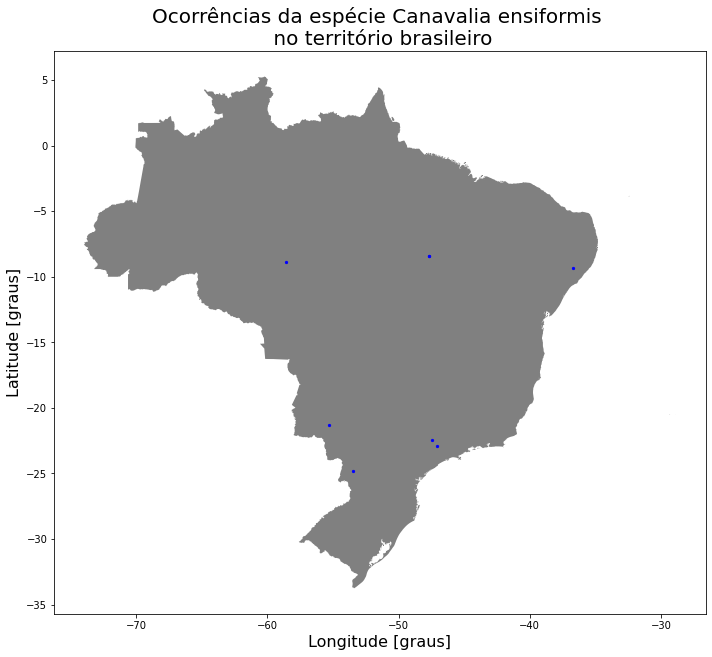

In this case GBIF request was necessary to create gdf file
Effectively 35 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

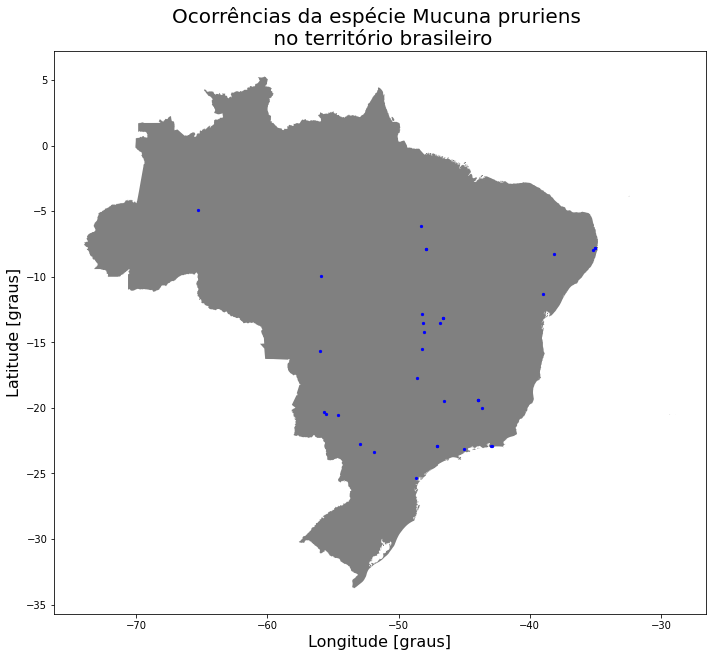

In this case GBIF request was necessary to create gdf file
Effectively 210 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

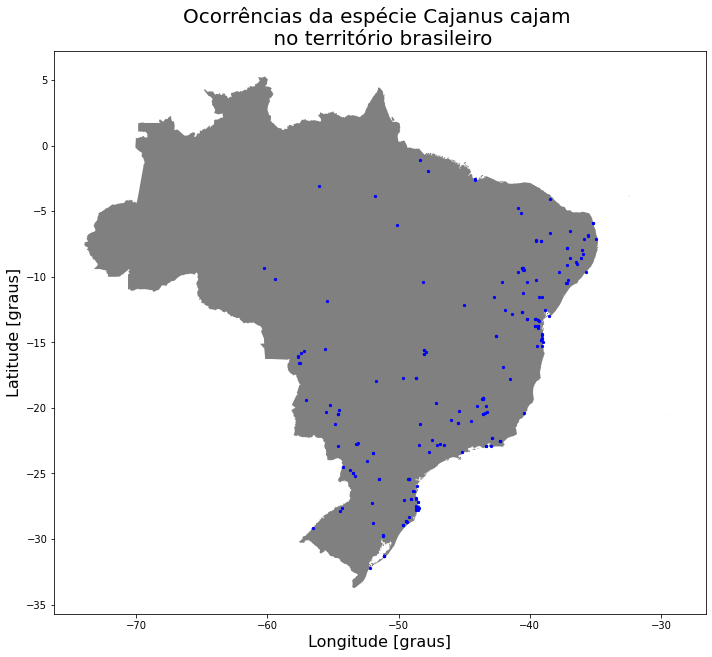

In this case GBIF request was necessary to create gdf file
Effectively 350 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

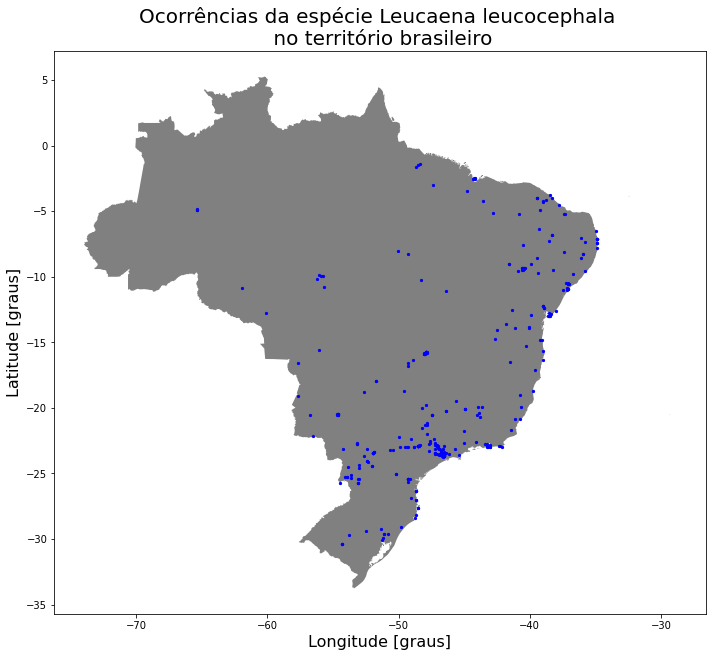

In this case GBIF request was necessary to create gdf file
Effectively 24 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

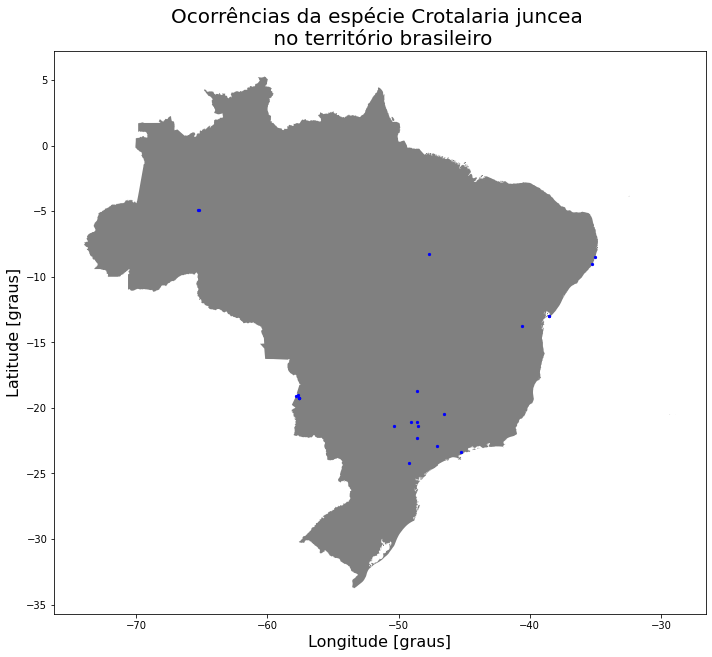

In this case GBIF request was necessary to create gdf file
Effectively 28 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

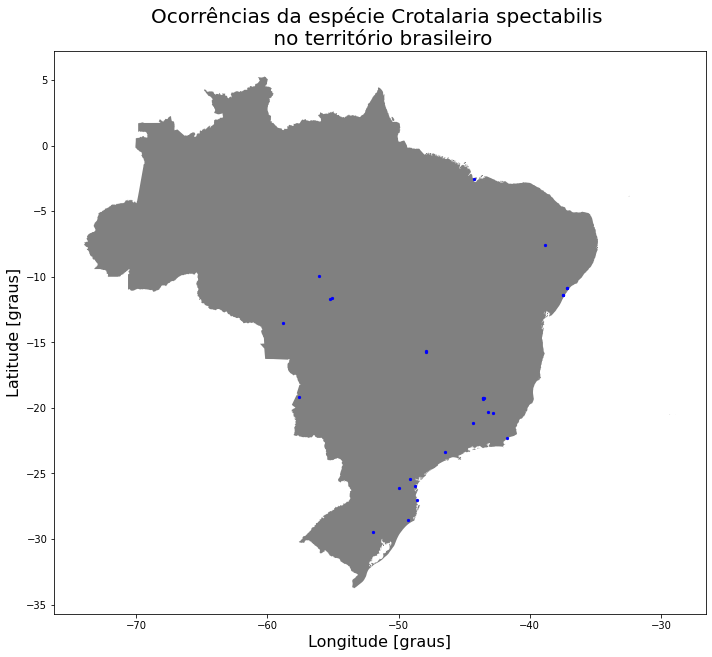

In this case GBIF request was necessary to create gdf file
Effectively 25 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

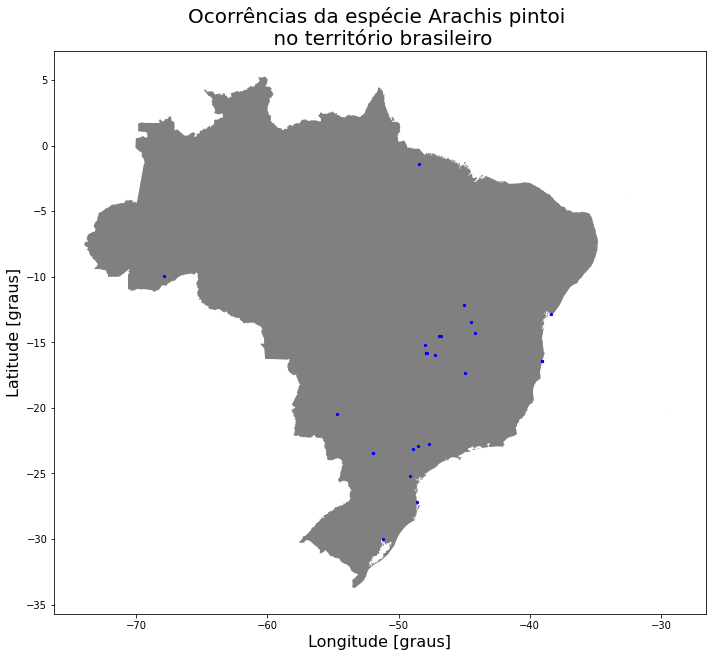

In this case GBIF request was necessary to create gdf file
Effectively 37 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

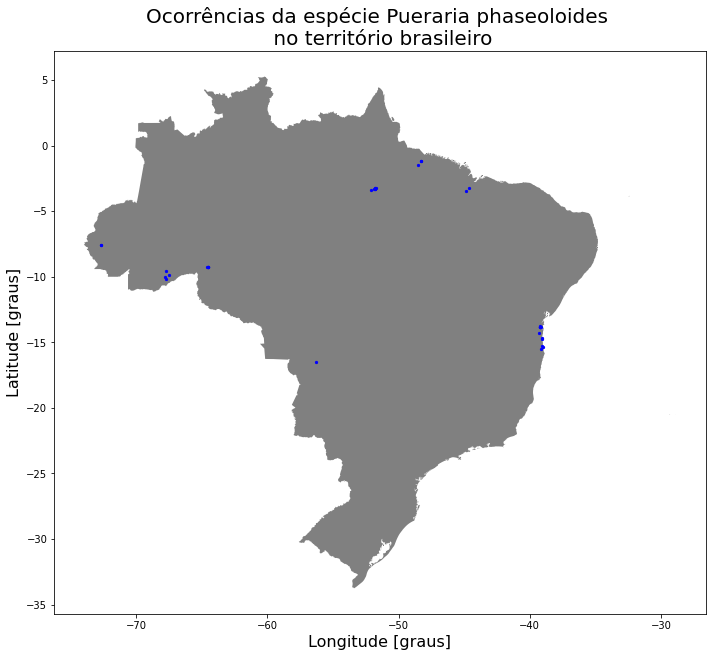

In this case GBIF request was necessary to create gdf file
Effectively 138 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

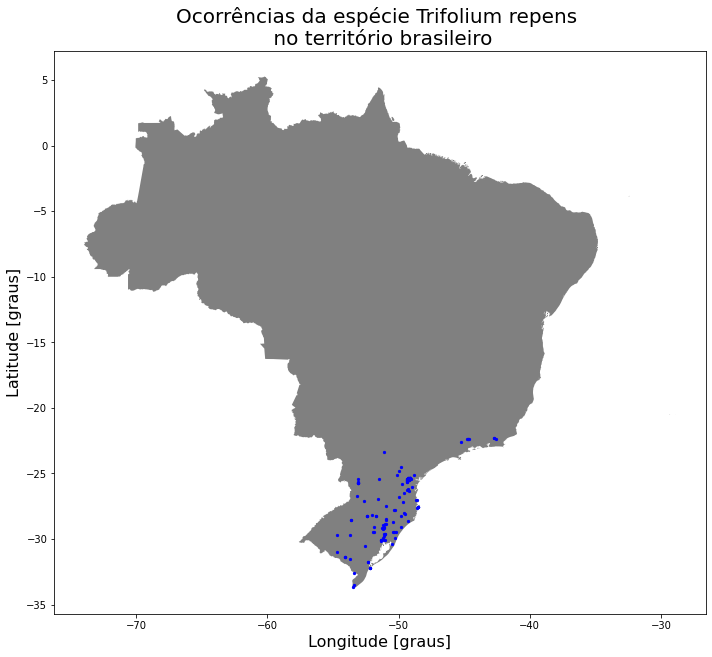

In this case GBIF request was necessary to create gdf file
Effectively 566 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

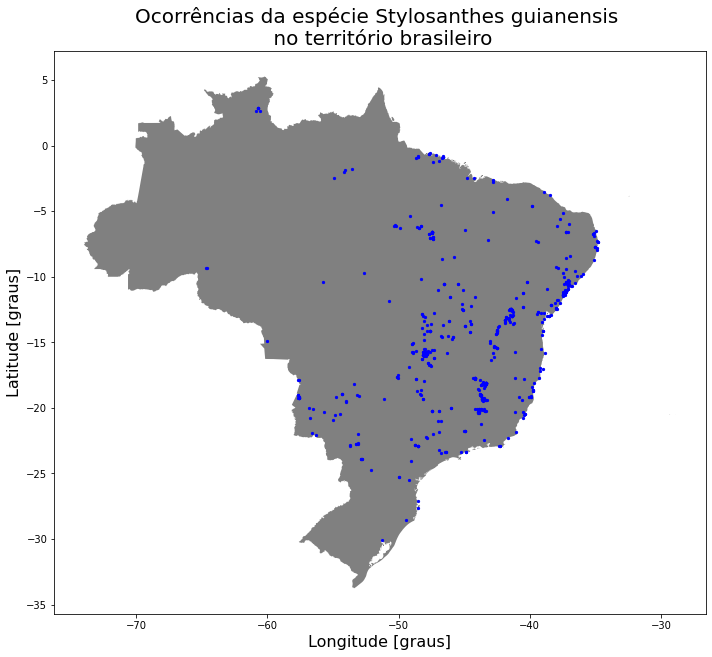

In this case GBIF request was necessary to create gdf file
Effectively 34 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

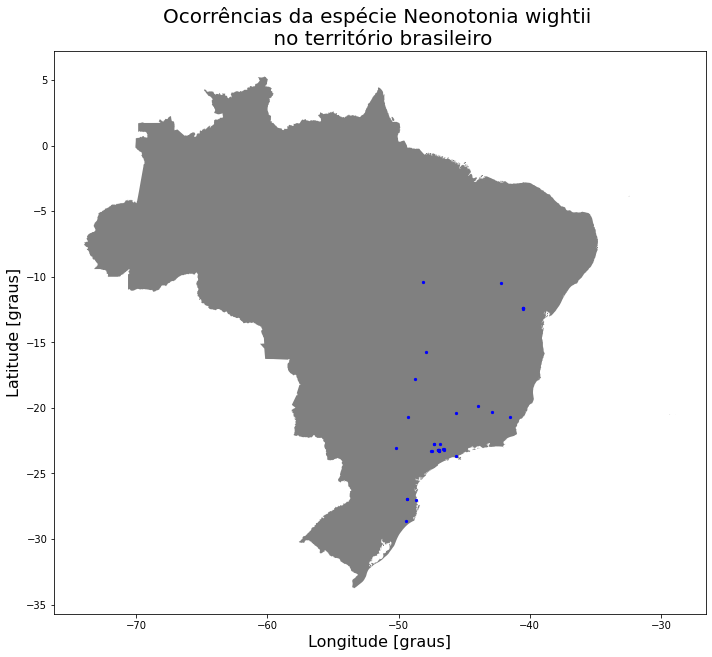

In this case GBIF request was necessary to create gdf file
Effectively 300 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

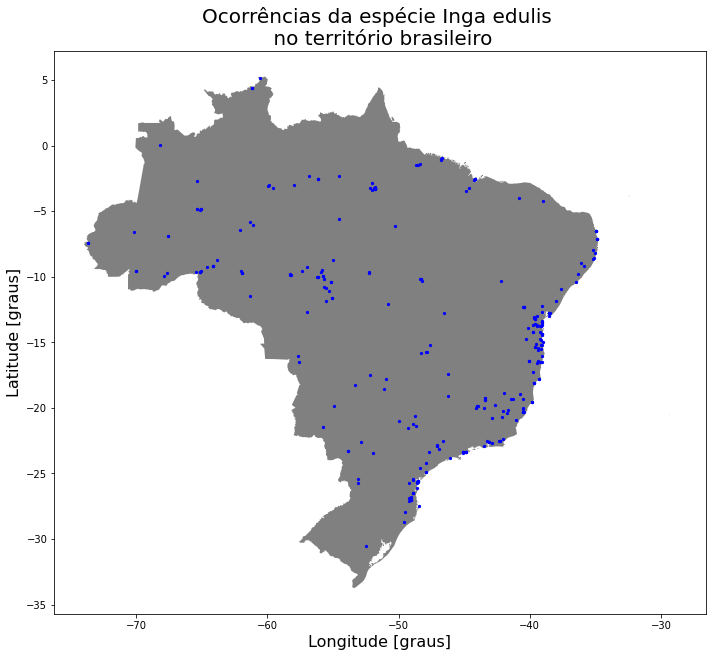

In this case GBIF request was necessary to create gdf file
Effectively 60 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

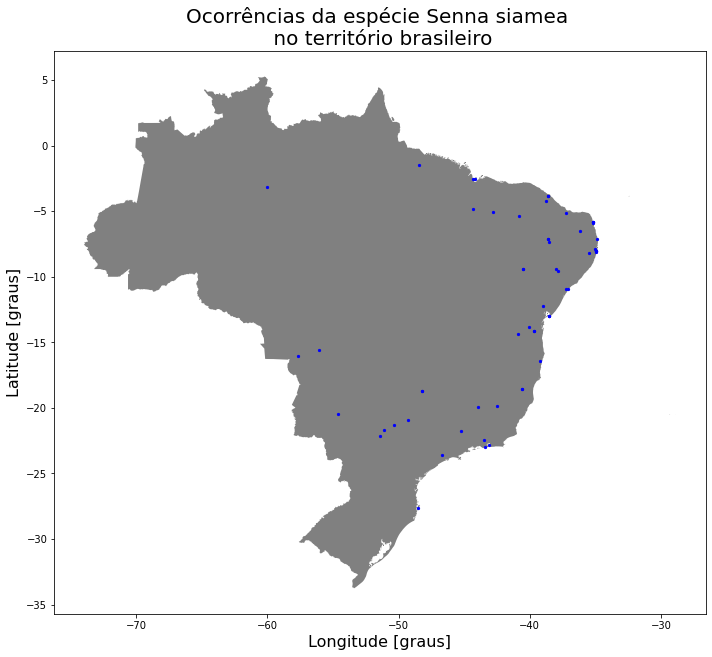

In this case GBIF request was necessary to create gdf file
Effectively 75 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

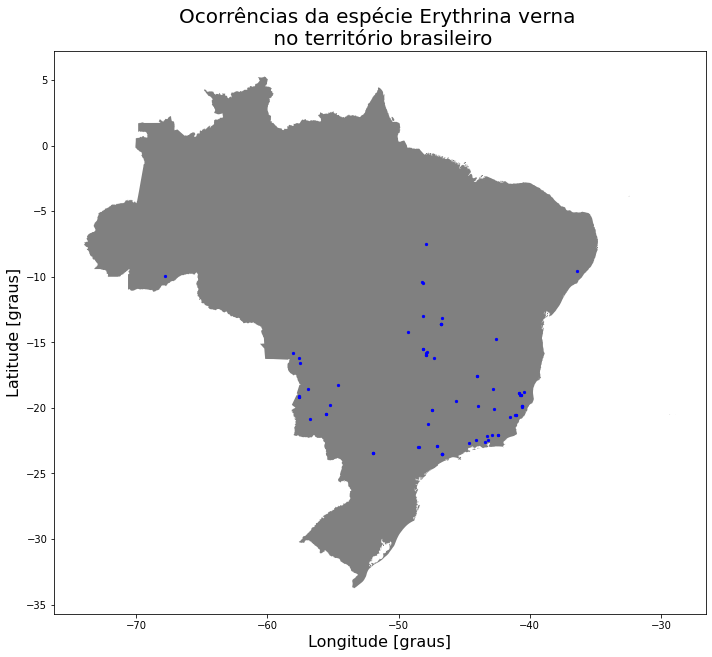

In this case GBIF request was necessary to create gdf file
Effectively 190 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

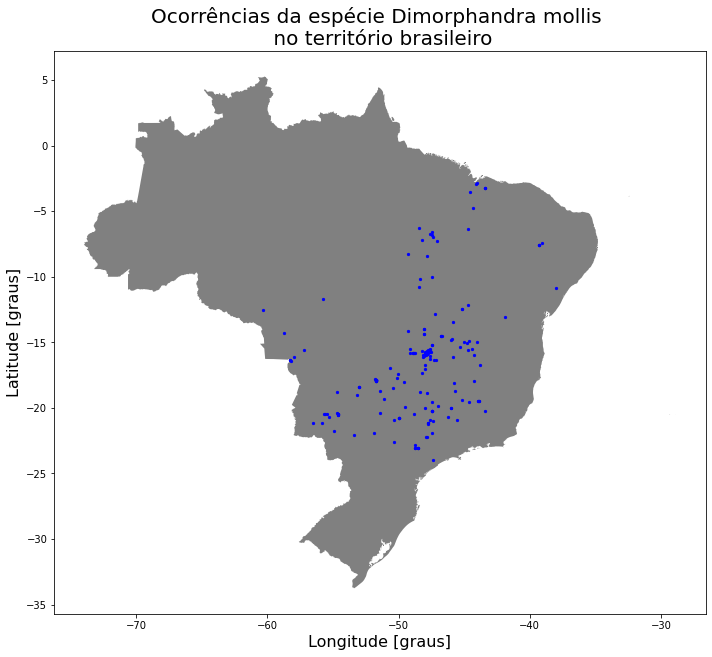

In this case GBIF request was necessary to create gdf file
Effectively 25 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

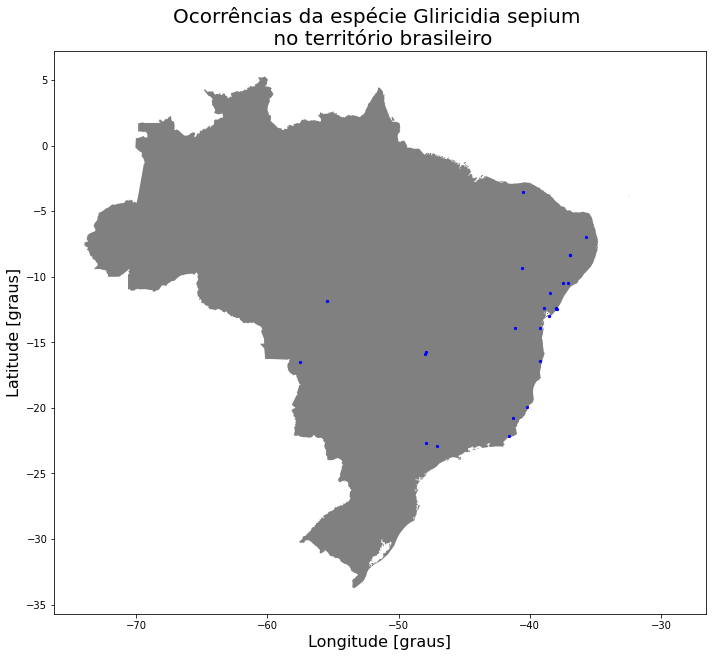

In this case GBIF request was necessary to create gdf file
Effectively 7 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

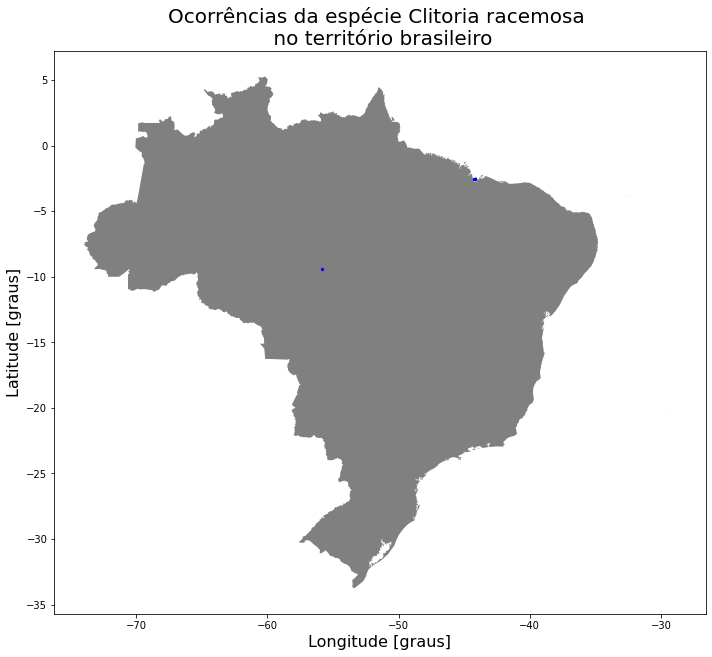

In this case GBIF request was necessary to create gdf file
Effectively 968 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

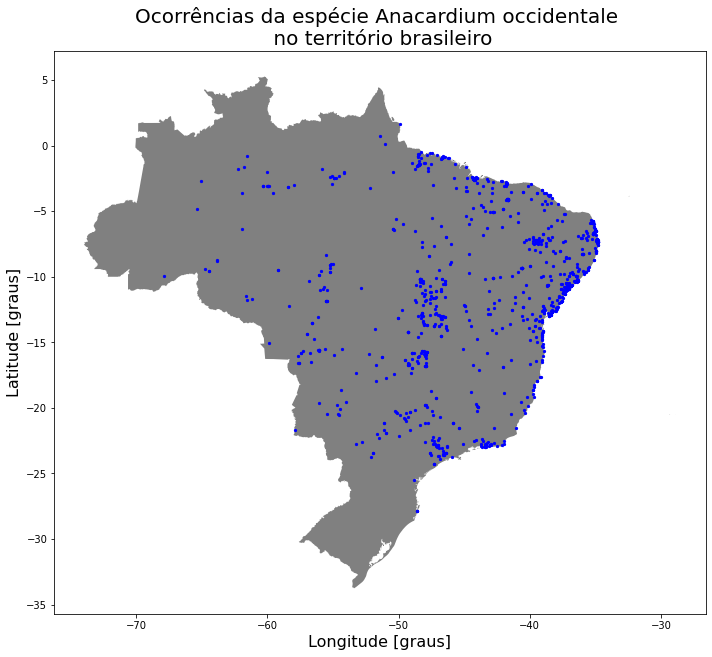

In this case GBIF request was necessary to create gdf file
Effectively 1166 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

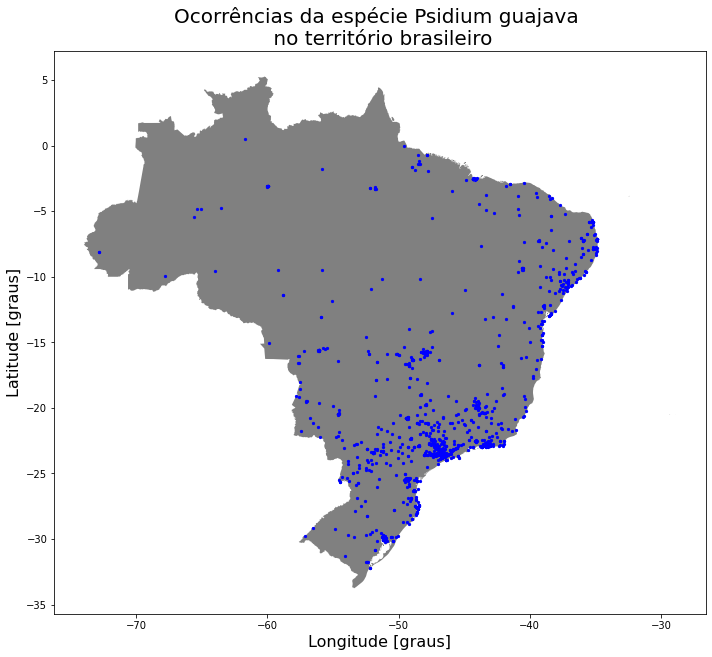

In this case GBIF request was necessary to create gdf file
Effectively 166 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

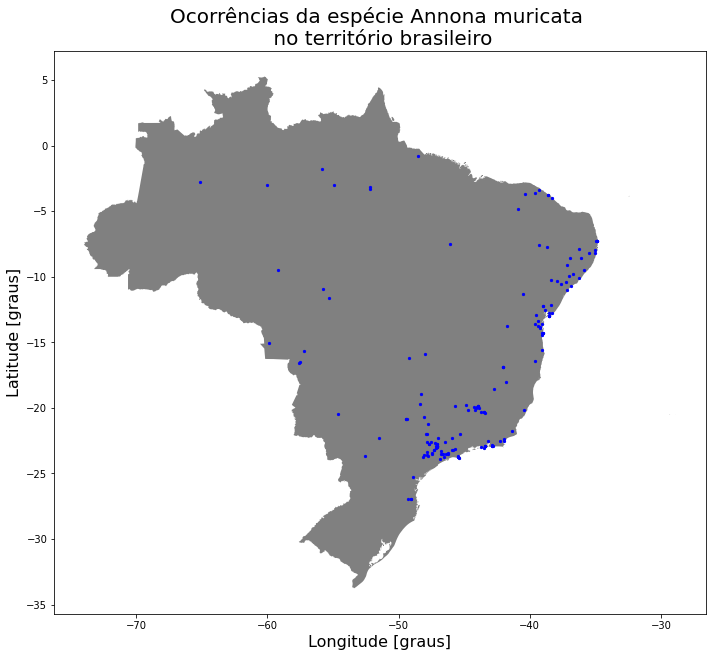

In this case GBIF request was necessary to create gdf file
Effectively 164 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

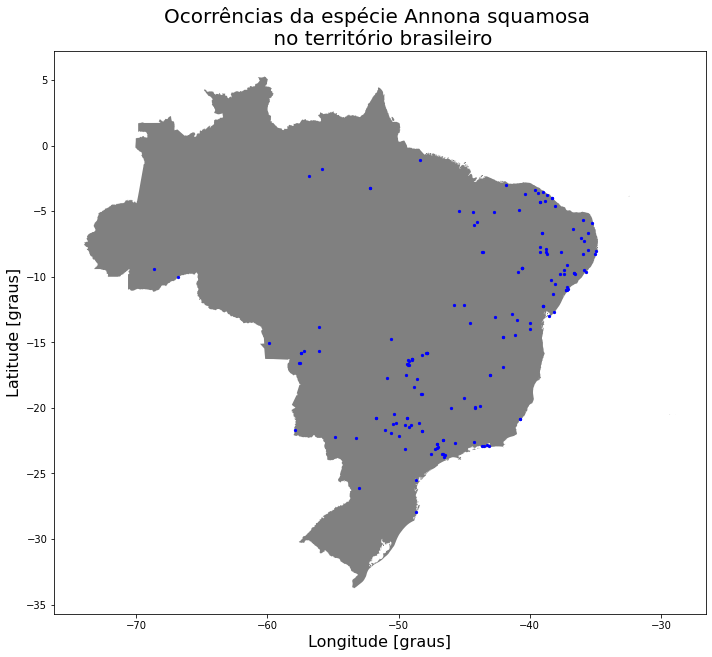

In this case GBIF request was necessary to create gdf file
Effectively 311 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

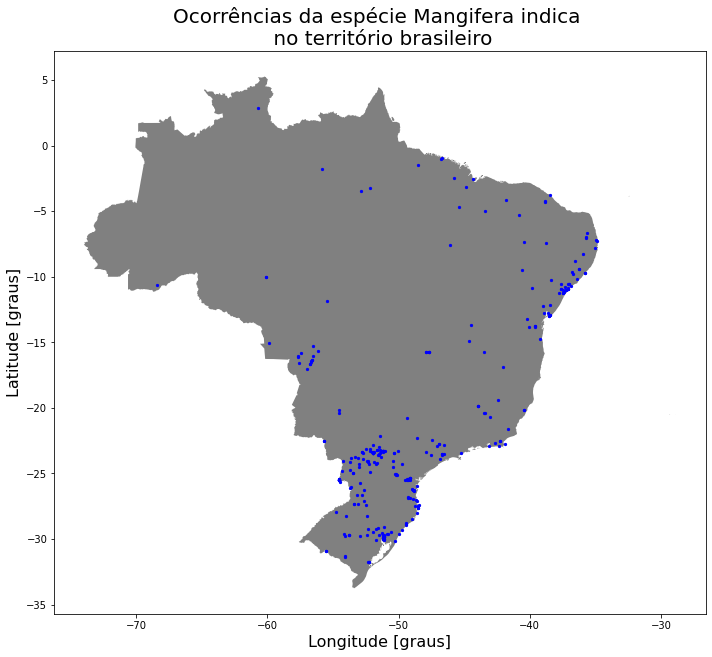

In this case GBIF request was necessary to create gdf file
Effectively 30 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

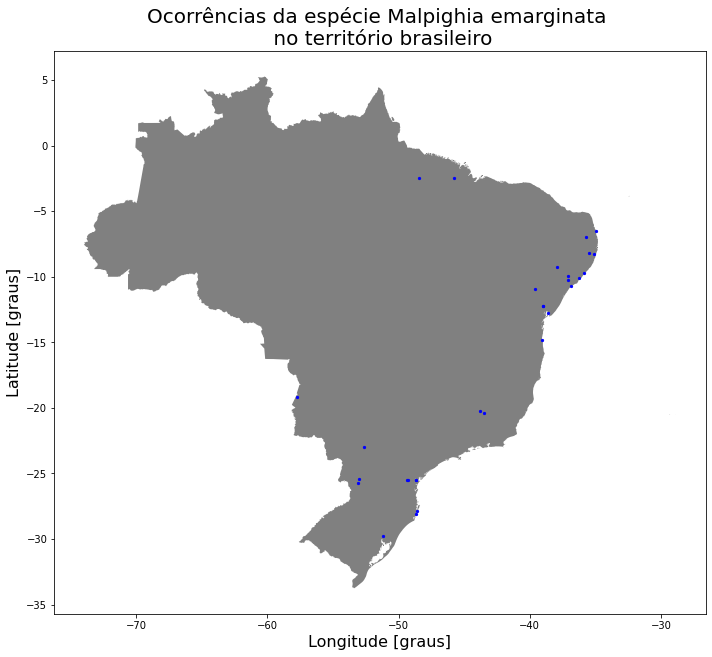

In this case GBIF request was necessary to create gdf file
Effectively 37 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

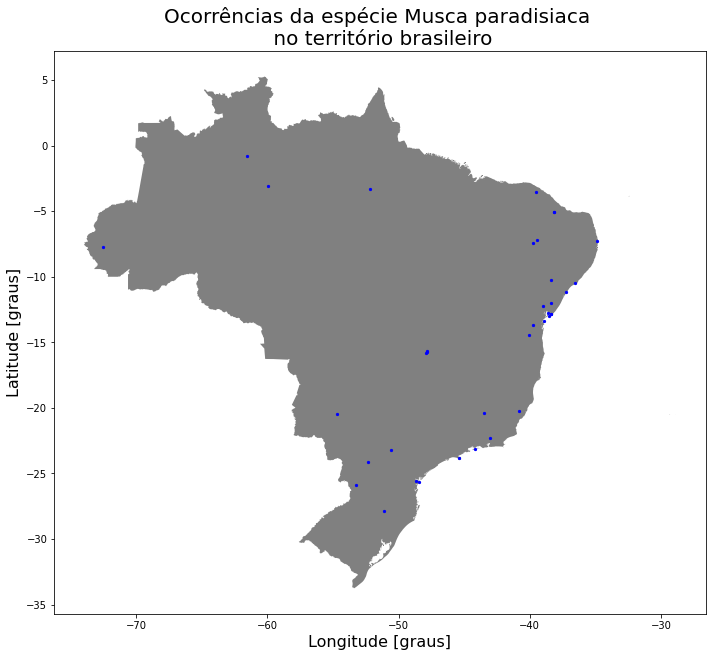

In this case GBIF request was necessary to create gdf file
Effectively 60 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

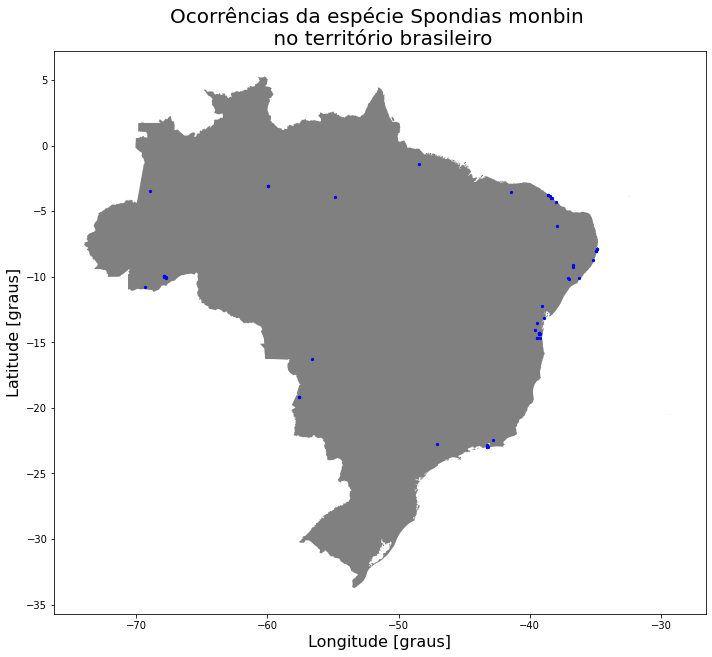

In this case GBIF request was necessary to create gdf file
Effectively 2288 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

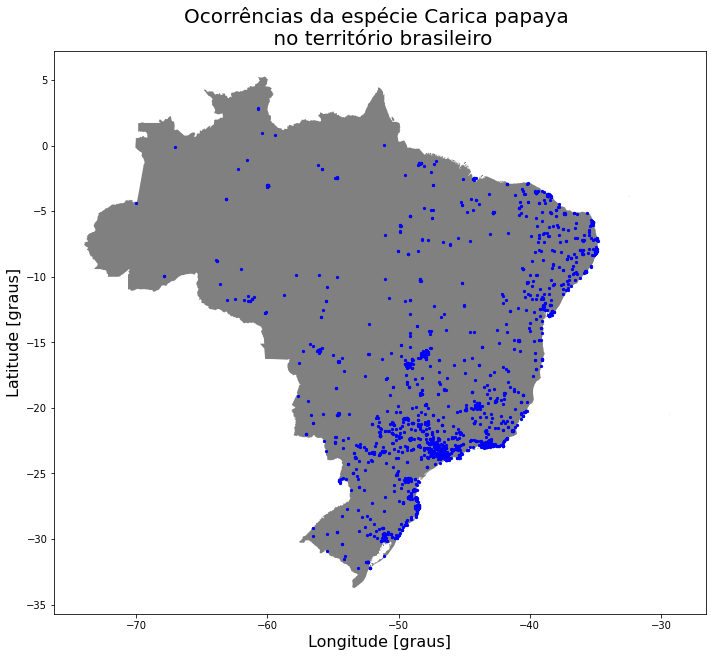

In this case GBIF request was necessary to create gdf file
Effectively 37 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

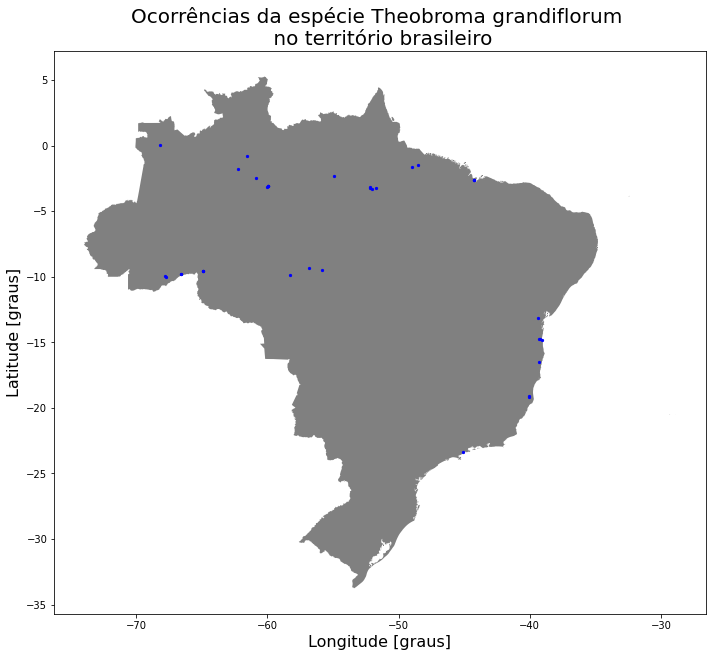

In this case GBIF request was necessary to create gdf file
Effectively 121 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

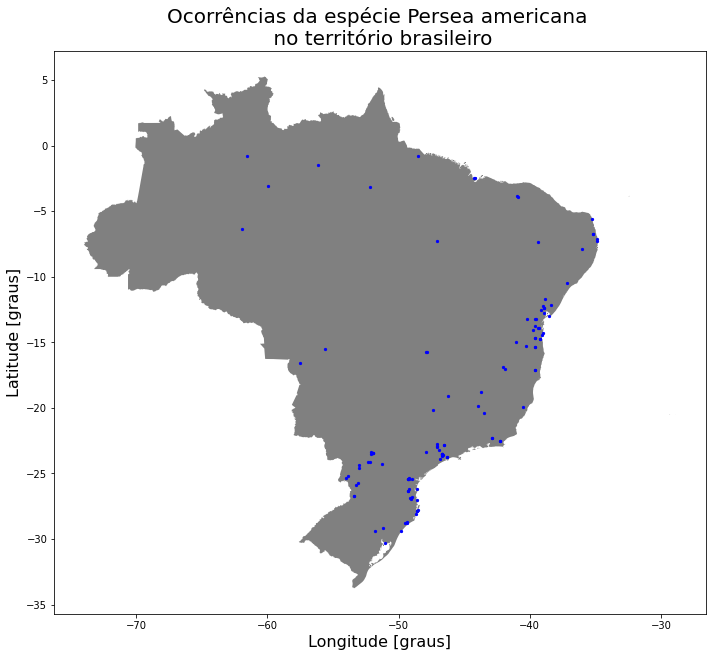

In this case GBIF request was necessary to create gdf file
Effectively 20 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

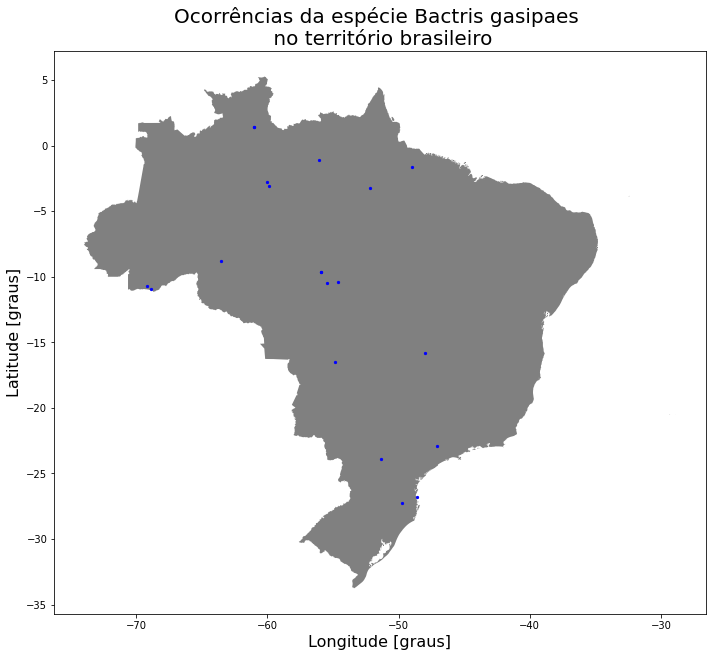

In this case GBIF request was necessary to create gdf file
Effectively 614 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

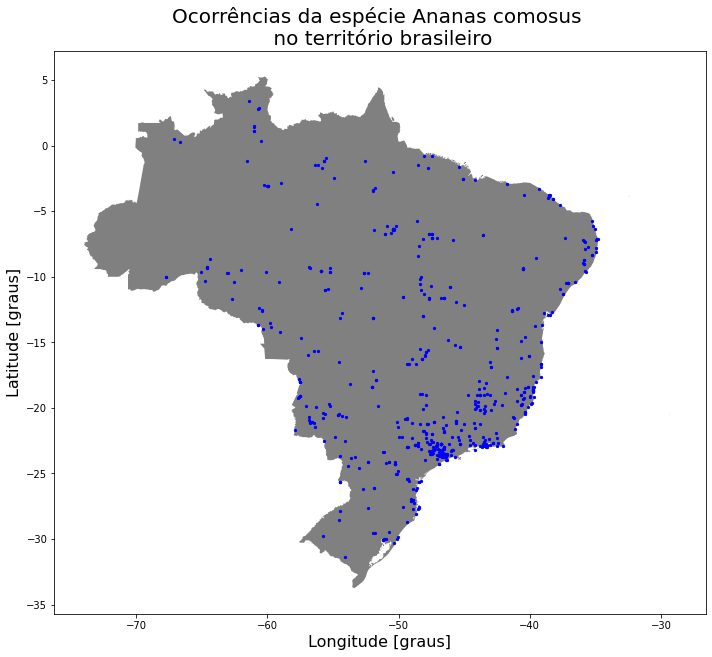

In this case GBIF request was necessary to create gdf file
Effectively 545 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

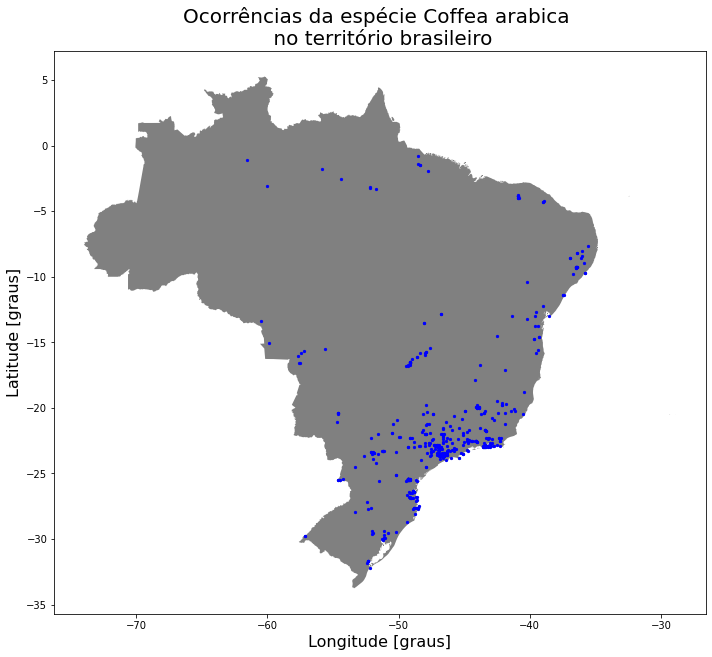

In this case GBIF request was necessary to create gdf file
Effectively 51 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

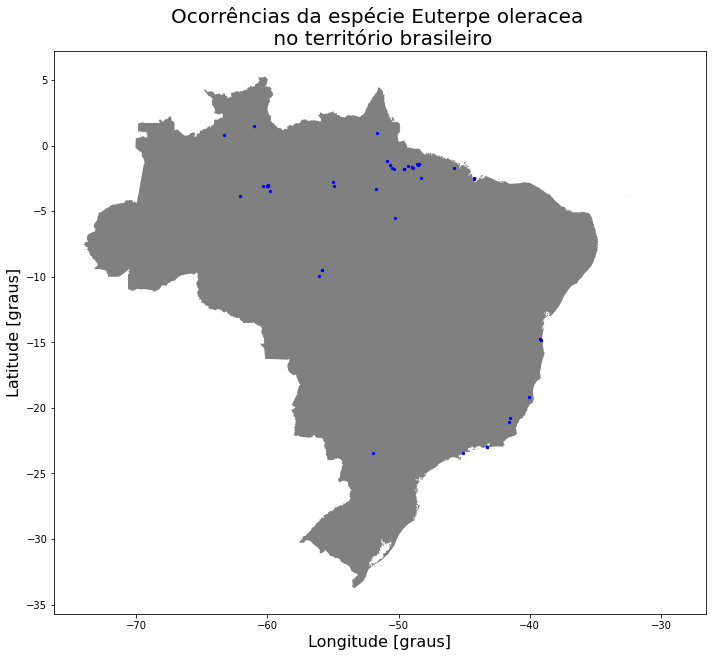

In this case GBIF request was necessary to create gdf file
Effectively 218 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

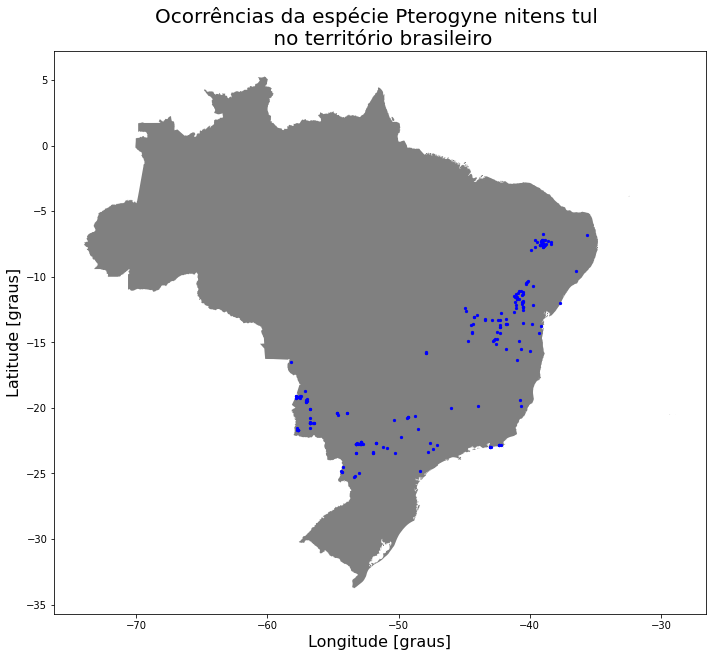

In this case GBIF request was necessary to create gdf file
Effectively 234 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

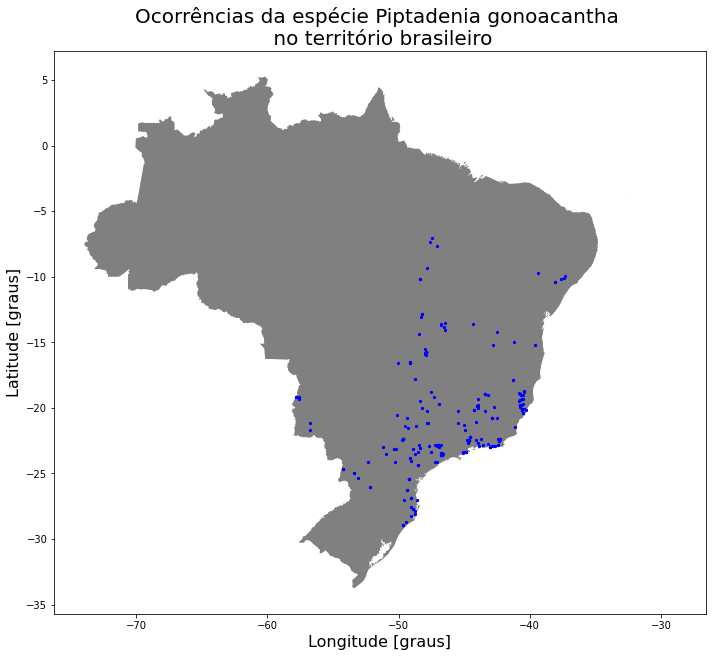

In this case GBIF request was necessary to create gdf file
Effectively 251 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

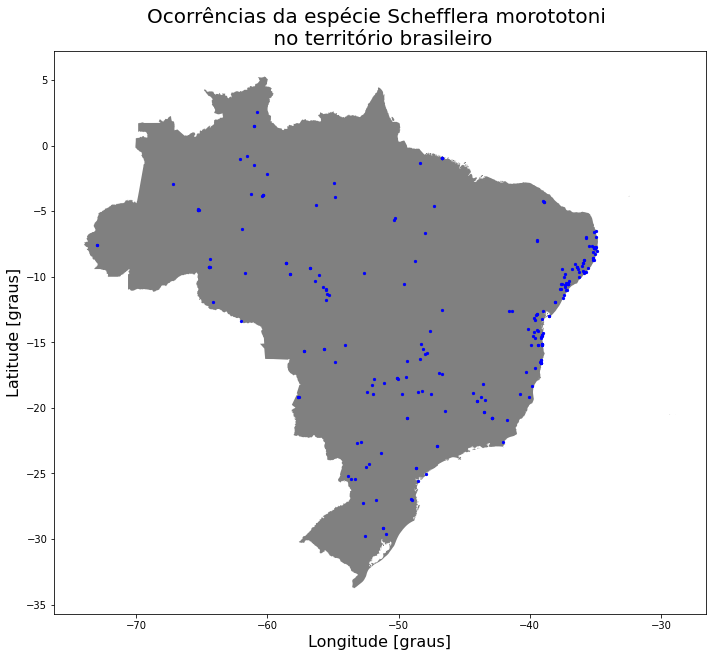

In this case GBIF request was necessary to create gdf file
Effectively 355 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

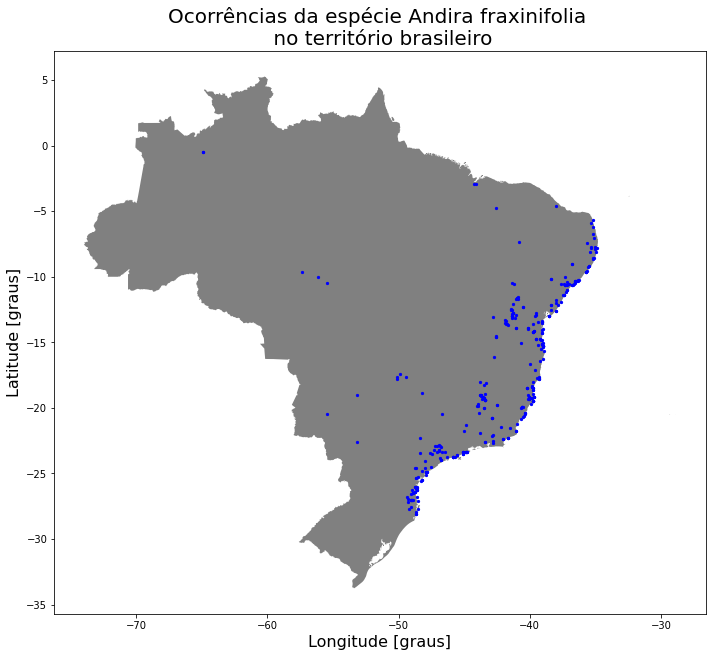

In this case GBIF request was necessary to create gdf file
Effectively 1317 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

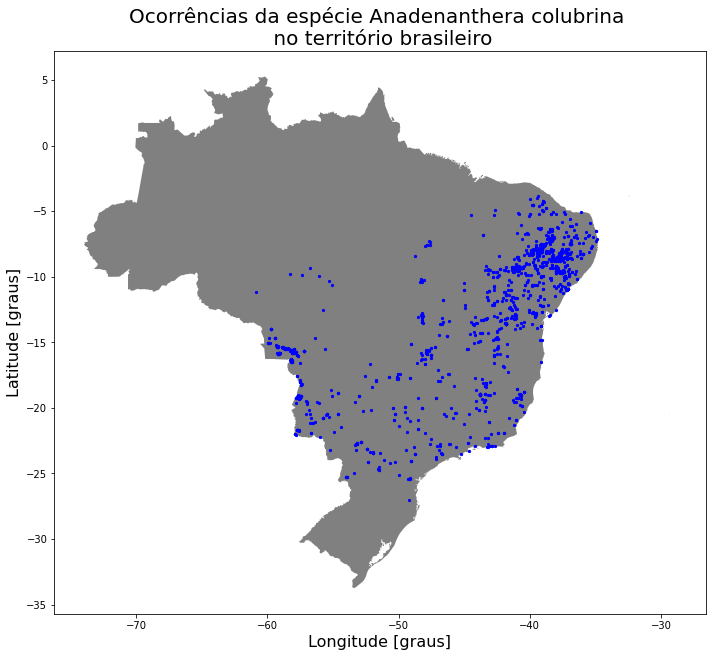

In this case GBIF request was necessary to create gdf file
Effectively 148 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

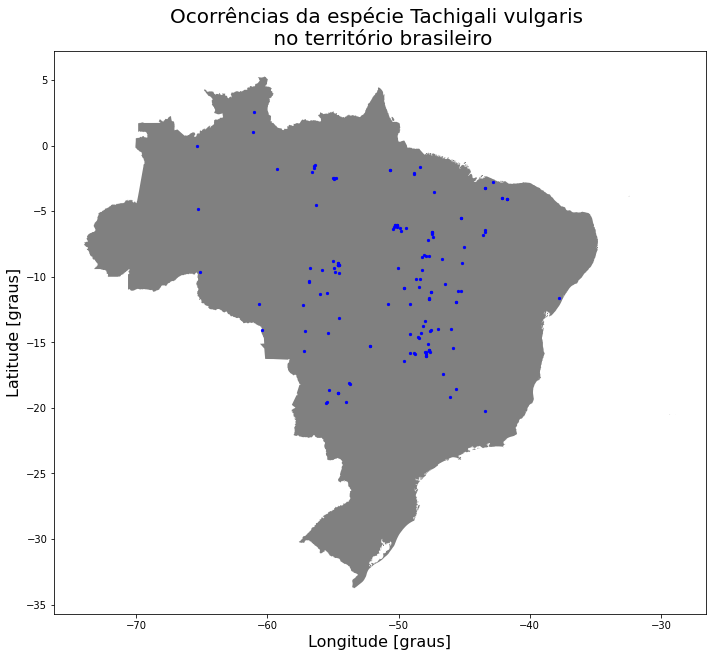

In this case GBIF request was necessary to create gdf file
Effectively 773 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

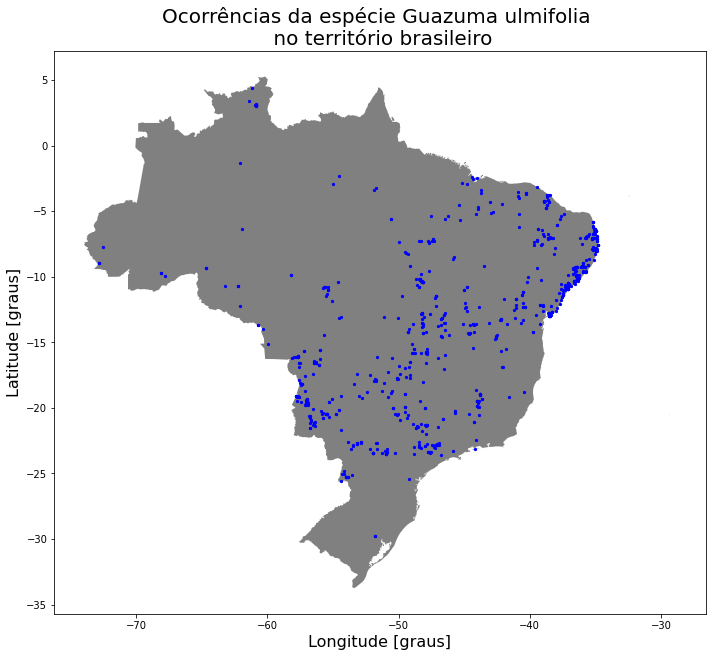

In this case GBIF request was necessary to create gdf file
Effectively 322 examplars are inside country boarders


<Figure size 432x288 with 0 Axes>

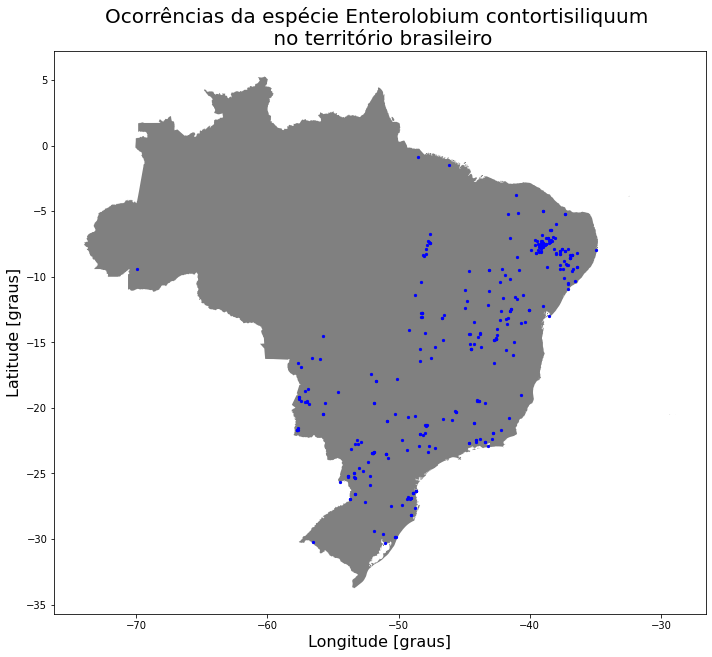

<Figure size 432x288 with 0 Axes>

In [ ]:
if collect_all:
  for tax_id, species_name in species_taxon_id_dict.items():
    specie = Specie(taxonKey=tax_id,
                species_name=species_name,
                  out_shapefile_parent_folder=result_gibf_queries_data_root_folder,
                  base_url=base_gbif_request_url,
                  countryObj=brazil,
                  limit=limit,
                  hasCoordinate=hasCoordinate,
                  lowYear=lowYear,
                  upYear=upYear,
                  dropDuplicates=dropDuplicates,
                  tryOverrideSpecieData=tryOverrideSpecieData)
  
    specie_gdf = specie.get_specie_gdf()
  
    plot_occurrences_on_map(specie_gdf=specie_gdf,
                            result_gibf_queries_maps_root_folder=result_gibf_queries_maps_root_folder,
                            species_name=species_name,
                            utils_methods=utils_methods,
                            brazil=brazil)
